In [53]:
import pandas as pd
import geopandas as gpd
import shapely
import networkx as nx
import matplotlib.pyplot as plt

/var/folders/v_/b1_tr5p9275_ry3qjq7b_pn00000gn/T/ipykernel_5835/1050444950.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sol_geom['geometry'] = sol_geom.apply(


<Axes: >

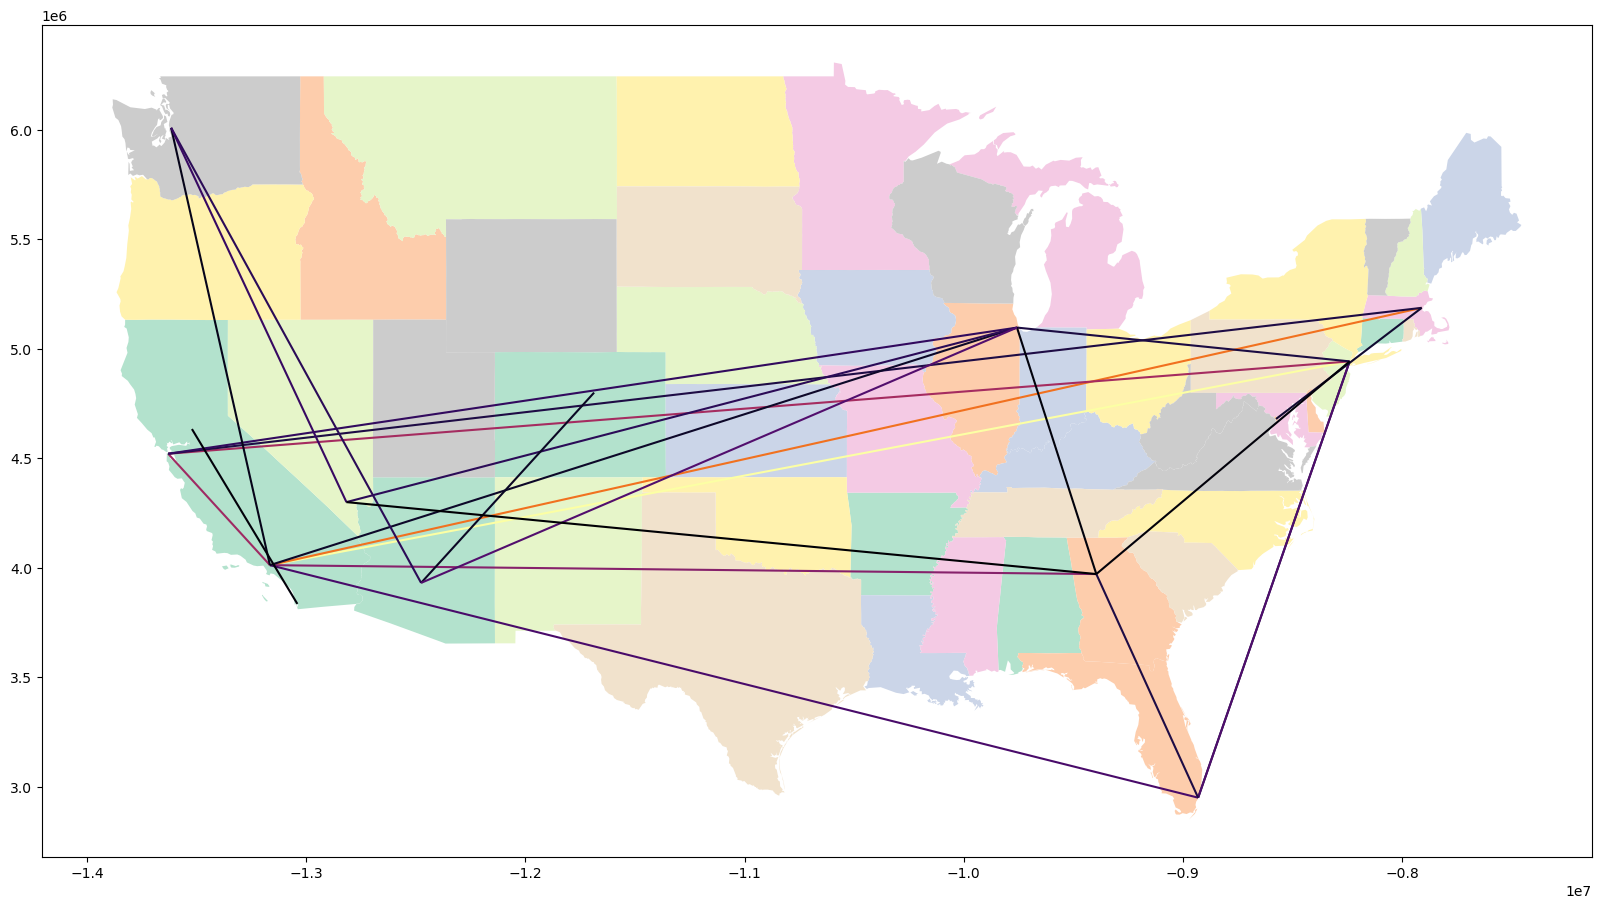

In [54]:
# read in solution and cities data
sol = pd.read_csv('../out/solution.csv')
cities_geom = gpd.read_file('../data/us-major-cities/USA_Major_Cities.shp')
og_crs = cities_geom.crs
cities_cols = ['NAME', 'ST', 'geometry']
cities_geom[cities_cols]

sol_cols = sol.columns
# first add the coords of the origin city
temp = sol.merge(
    cities_geom[cities_cols],
    how='inner',
    left_on=['city_origin', 'state_origin'],
    right_on=['NAME', 'ST']
).rename(columns={'geometry': 'pt_origin'})
# then add the coords of the dest city
temp = temp.merge(
    cities_geom[cities_cols],
    how='inner',
    left_on=['city_dest', 'state_dest'],
    right_on=['NAME', 'ST']
).rename(columns={'geometry': 'pt_dest'})
sol_geom = temp[['pt_origin', 'pt_dest']]
# create line segments from city points
sol_geom['geometry'] = sol_geom.apply(
    lambda row: shapely.LineString((row['pt_origin'], row['pt_dest'])),
    axis='columns'
)

sol_geo = gpd.GeoDataFrame(sol, geometry=sol_geom['geometry'], crs=og_crs)  # type: ignore
states = gpd.read_file('../data/us-states/States_shapefile.shp').to_crs(epsg=3395)
# remove AK and HI
states: gpd.GeoDataFrame = states[(states['State_Code'] != 'AK') & (states['State_Code'] != 'HI')]  # type: ignore

fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(20, 20))
ax1 = states.plot(ax=ax1, cmap='Pastel2')
sol_geo.to_crs(epsg=3395).plot(ax=ax1, column='co2_g', cmap='inferno')

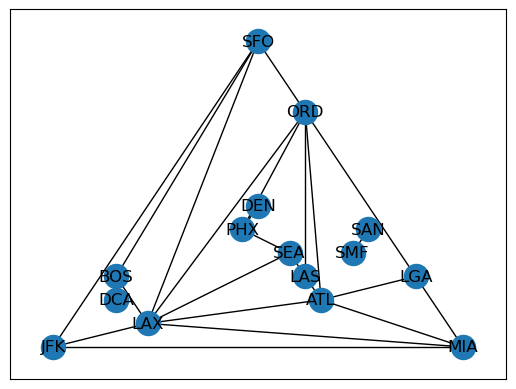

In [55]:
G = nx.from_pandas_edgelist(sol_geo, source='Origin', target='Dest', edge_attr='NonStopKm')
nx.draw_networkx(G, pos=nx.planar_layout(G))

{('JFK', 'LAX'): Text(-0.10620682149807088, -0.08040362596567666, '3983.1165'),
 ('JFK',
  'SFO'): Text(-0.14046417254783738, -0.09421502134820911, '4161.75324'),
 ('JFK',
  'MIA'): Text(-0.09801612374322693, -0.012808078357339377, '1752.57126'),
 ('LAX',
  'ORD'): Text(-0.004636939648905797, -0.1323310021753651, '2806.68896'),
 ('LAX',
  'BOS'): Text(-0.15034673837428275, -0.16103588228255153, '4201.98674'),
 ('LAX',
  'ATL'): Text(-0.004392013589861528, -0.08798357519137098, '3133.38498'),
 ('LAX', 'SFO'): Text(-0.09523737346322532, -0.13840616986949836, '542.34758'),
 ('LAX', 'SEA'): Text(0.012448581651255251, -0.1764756030239919, '1535.31036'),
 ('LAX',
  'MIA'): Text(-0.05278932465861487, -0.056999226878628614, '3769.07428'),
 ('SFO',
  'BOS'): Text(-0.18460408942404927, -0.17484727766508398, '4351.65536'),
 ('SFO', 'ORD'): Text(-0.0388942906986723, -0.14614239755789754, '2970.84164'),
 ('ORD',
  'LGA'): Text(0.06070637490711444, -0.057901065888608626, '1179.64622'),
 ('ORD', 'PHX

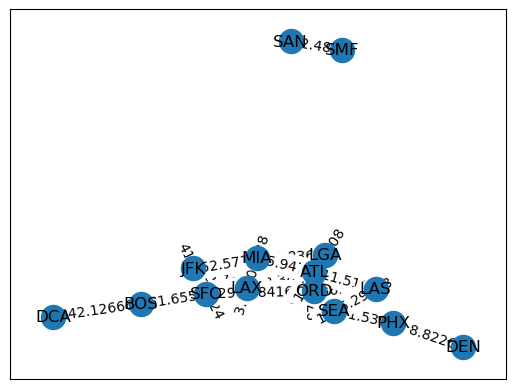

In [56]:
pos=nx.spring_layout(G)
nx.draw_networkx(G,pos)
labels = nx.get_edge_attributes(G,'NonStopKm')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

In [57]:
nx.shortest_path(G, source='ORD', weight='NonStopKm')

{'ORD': ['ORD'],
 'LAX': ['ORD', 'LAX'],
 'LGA': ['ORD', 'LGA'],
 'SFO': ['ORD', 'SFO'],
 'PHX': ['ORD', 'PHX'],
 'LAS': ['ORD', 'LAS'],
 'ATL': ['ORD', 'ATL'],
 'MIA': ['ORD', 'ATL', 'MIA'],
 'JFK': ['ORD', 'ATL', 'MIA', 'JFK'],
 'DEN': ['ORD', 'PHX', 'DEN'],
 'SEA': ['ORD', 'LAS', 'SEA'],
 'BOS': ['ORD', 'LAX', 'BOS'],
 'DCA': ['ORD', 'LAX', 'BOS', 'DCA']}